In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import os
import sys
import nltk

In [12]:
inter_target_folder = '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split'
extra_target_folder = '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split'

# The following 4 lists have to match so that the element at each index is correct
inter_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns']

extra_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns']

results_folders_inter = ['/Users/ff/results_20200303/results_interpolation_100k/',
                         '/Users/ff/results_20200312/risk_full_20200312_inter/',
                         '/Users/ff/results_20200314/risk_full_20200314_inter/',
                         '/Users/ff/results_20200314_27000/risk_full_20200314_inter_27000/',
                         '/Users/ff/results_risk_len_20200323/risk_len_20200323_inter_37000/',
                         '/Users/ff/results_baseline_norm_tok_20200328/baseline_norm_tok_20200328_inter_96000/',
                         '/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_inter_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_inter_40000',
                         '/Users/ff/results_ns_20200316/ns_20200316_inter_96000']


results_folders_extra = ['/Users/ff/results_20200303/results_extrapolation_100k/',
                         '/Users/ff/results_20200312/risk_full_20200312_extra/',
                         '/Users/ff/results_20200314/risk_full_20200314_extra/',
                         '/Users/ff/results_20200314_27000/risk_full_20200314_extra_27000/',
                         '/Users/ff/results_risk_len_20200323/risk_len_20200323_extra_37000/',
                         '/Users/ff/results_baseline_norm_tok_20200328/baseline_norm_tok_20200328_extra_96000/',
                         '/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_extra_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_extra_40000',
                         '/Users/ff/results_ns_20200316/ns_20200316_extra_96000']

In [13]:
# The following 4 lists have to match so that the element at each index is correct
inter_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns']

extra_target_folders = ['/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns',
                        '/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns']

results_folders_extra = ['/Users/ff/results_20200303/results_extrapolation_100k/',
                         '/Users/ff/results_ns_20200316/ns_20200316_extra_96000',
                         #'/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_extra_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_extra_40000']




results_folders_inter = ['/Users/ff/results_20200303/results_interpolation_100k/',
                         '/Users/ff/results_ns_20200316/ns_20200316_inter_96000',
                         #'/Users/ff/results_risk_irm_ns_20200328_27000/risk_irm_ns_20200328_inter_27000',
                         '/Users/ff/results_risk_irm_ns_20200328_40000/risk_irm_ns_20200328_inter_40000']





In [32]:
pretty_names = {
    'results_extrapolation_100k':'Baseline',
    'ns_20200316_extra_96000':'NS',
    'risk_irm_ns_20200328_extra_27000':'NS + IRM (27k)',
    'risk_irm_ns_20200328_extra_40000':'NS + IRM',
    'results_interpolation_100k':'Baseline',
    'ns_20200316_inter_96000':'NS',
    'risk_irm_ns_20200328_inter_27000':'NS + IRM (27k)',
    'risk_irm_ns_20200328_inter_40000':'NS + IRM'
}


targets_inter_names = {'algebra__polynomial_roots':'alg_poly_roots',
                 'arithmetic__add_or_sub':'arith_add_sub',
                 'arithmetic__add_sub_multiple':'arith_add_sub_mult',
                 'arithmetic__div':'arith_div',
                 'arithmetic__mixed':'arith_mix',
                 'arithmetic__mul_div_multiple':'arith_mul_div_mult',
                 'arithmetic__mul':'arith_mul',
                 'comparison__closest':'comp_closest',
                 'comparison__kth_biggest':'comp_kth_big',
                 'comparison__sort':'comp_sort',
                 'measurement__conversion':'meas_conv',
                 'numbers__place_value':'num_place_val',
                 'numbers__round_number':'num_round_num',
                 'probability__swr_p_level_set':'prob_swr_p_level',
                 'probability__swr_p_sequence':'prob_swr_p_seq'}

inter_targets = sorted(['algebra__polynomial_roots_tgt_test.txt',
                 'arithmetic__add_or_sub_tgt_test.txt',
                 'arithmetic__add_sub_multiple_tgt_test.txt',
                 'arithmetic__div_tgt_test.txt',
                 'arithmetic__mixed_tgt_test.txt',
                 'arithmetic__mul_div_multiple_tgt_test.txt',
                 'arithmetic__mul_tgt_test.txt',
                 'comparison__closest_tgt_test.txt',
                 'comparison__kth_biggest_tgt_test.txt',
                 'comparison__sort_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_tgt_test.txt',
                 'numbers__round_number_tgt_test.txt',
                 'probability__swr_p_level_set_tgt_test.txt',
                 'probability__swr_p_sequence_tgt_test.txt'])

targets_extra_names = {'algebra__polynomial_roots_big':'alg_poly_roots',
                 'arithmetic__add_or_sub_big':'arith_add_sub',
                 'arithmetic__add_sub_multiple_longer':'arith_add_sub_mult',
                 'arithmetic__div_big':'arith_div',
                 'arithmetic__mixed_longer':'arith_mix',
                 'arithmetic__mul_div_multiple_longer':'arith_mul_div_mult',
                 'arithmetic__mul_big':'arith_mul',
                 'comparison__closest_more':'comp_closest',
                 'comparison__kth_biggest_more':'comp_kth_big',
                 'comparison__sort_more':'comp_sort',
                 'measurement__conversion':'meas_conv',
                 'numbers__place_value_big':'num_place_val',
                 'numbers__round_number_big':'num_round_num',
                 'probability__swr_p_level_set_more_samples':'prob_swr_p_level',
                 'probability__swr_p_sequence_more_samples':'prob_swr_p_seq'}


extra_targets = sorted(['algebra__polynomial_roots_big_tgt_test.txt',
                 'arithmetic__add_or_sub_big_tgt_test.txt',
                 'arithmetic__add_sub_multiple_longer_tgt_test.txt',
                 'arithmetic__div_big_tgt_test.txt',
                 'arithmetic__mixed_longer_tgt_test.txt',
                 'arithmetic__mul_big_tgt_test.txt',
                 'arithmetic__mul_div_multiple_longer_tgt_test.txt',
                 'comparison__closest_more_tgt_test.txt',
                 'comparison__kth_biggest_more_tgt_test.txt',
                 'comparison__sort_more_tgt_test.txt',
                 'measurement__conversion_tgt_test.txt',
                 'numbers__place_value_big_tgt_test.txt',
                 'numbers__round_number_big_tgt_test.txt',
                 'probability__swr_p_level_set_more_samples_tgt_test.txt',
                 'probability__swr_p_sequence_more_samples_tgt_test.txt'])

In [33]:
def pair_files_in_folders(folders):
    res = {}
    for folder in sorted(folders):
        res[folder] = []
        for file in sorted(os.listdir(folder)):
            if file.endswith(".txt"):
                res[folder].append(os.path.join(folder, file))
    return res

In [34]:
extra_hyp_files = pair_files_in_folders(results_folders_extra)
inter_hyp_files = pair_files_in_folders(results_folders_inter)

In [69]:
def compute_accuracies(ref_lines, hyp_lines):
    bleus = np.zeros(len(ref_lines))
    accs = np.zeros(len(ref_lines))

    # https://www.nltk.org/_modules/nltk/translate/bleu_score.html
    smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
    
    for i, (ref_line, hyp_line) in enumerate(zip(ref_lines, hyp_lines)):
        ref = ref_line.strip().split(' ')
        refs = [ref]
        hyp = hyp_line.strip().split(' ')
        #bleu = nltk.translate.bleu_score.sentence_bleu(refs, hyp, smoothing_function=smoothing_function)
        #bleus[i] = bleu
        accs[i] = (1 if np.array_equal(ref,hyp) else 0)

    #list_of_references = [[s.strip().split(' ')] for s in ref_lines]
    #hypotheses = [s.strip().split(' ') for s in hyp_lines]
    #corpus_bleu = nltk.translate.bleu_score.corpus_bleu(list_of_references, hypotheses)

    return (accs)#, bleus, corpus_bleu



def label_bars(ax, bars, text_format, **kwargs):
    """
    Attaches a label on every bar of a regular or horizontal bar chart
    """
    ys = [bar.get_y() for bar in bars]
    y_is_constant = all(y == ys[0] for y in ys)  # -> regular bar chart, since all all bars start on the same y level (0)

    if y_is_constant:
        _label_bar(ax, bars, text_format, **kwargs)
    else:
        _label_barh(ax, bars, text_format, **kwargs)


def _label_bar(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    """
    max_y_value = ax.get_ylim()[1]
    inside_distance = max_y_value * 0.05
    outside_distance = max_y_value * 0.01

    for bar in bars:
        text = text_format.format(bar.get_height())
        text_x = bar.get_x() + bar.get_width() / 2

        is_inside = bar.get_height() >= max_y_value * 0.15
        if is_inside:
            color = "white"
            text_y = bar.get_height() - inside_distance
        else:
            color = "black"
            text_y = bar.get_height() + outside_distance

        ax.text(text_x, text_y, text, ha='center', va='bottom', color=color, **kwargs)


def _label_barh(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    Note: label always outside. otherwise it's too hard to control as numbers can be very long
    """
    max_x_value = ax.get_xlim()[1]
    distance = max_x_value * 0.0025

    for bar in bars:
        text = text_format.format(bar.get_width())

        text_x = bar.get_width() + distance
        text_y = bar.get_y() + bar.get_height() / 2

        ax.text(text_x, text_y, text, va='center', **kwargs)

        
def plot_accuracies(targets, targets_folders, hyp_files, names, title, file=None):
    fig, ax = plt.subplots(1, figsize=(8,3))
    
    plt.tight_layout()
    #plt.title(title, fontsize=14)
    colors = ['b', 'g', 'r', 'y', ]
    
    bars = []
    bar_width = 1 / (len(hyp_files) + 1)
    for i in range(len(hyp_files)):
        bars.append(np.arange(len(targets)) + bar_width * i)
    bars_ = []
    accuracies = np.zeros(len(hyp_files))    
    n_sentences = 0
    
    for i, t in enumerate(targets):
        prev_target = ''
        
        for j,key in enumerate(sorted(hyp_files.keys())):
            target = os.path.join(targets_folders[j], t)
            
            # Avoid loading targets too many times
            if target != prev_target:
                prev_target = target
                with open(target, 'r') as f:
                    ref_lines = f.readlines()
                    n_sentences = len(ref_lines)
                    
            # Read files
            with open(os.path.join(hyp_files[key][i]), 'r') as f:
                hyp_lines = f.readlines()
                
            accs = compute_accuracies(ref_lines, hyp_lines)

            print(os.path.basename(os.path.normpath(hyp_files[key][i])), accs.mean())
            bars_.append(ax.bar(bars[j][i], accs.sum()/len(accs), color=get_cmap('tab10').colors[j], width=bar_width, alpha=0.9))
            
            accuracies[j] += accs.sum()
        print()     
    ax.set_xticks(bars[len(bars)//2])
    ax.set_xticklabels([names[t.replace('_tgt_test.txt','')] for t in targets], 
                       rotation=30, ha='right', 
                       fontsize=13)
    plt.ylabel('Binary Accuracy', fontsize=13)
    #plt.legend([os.path.basename(os.path.normpath(p))] for p in sorted(hyp_files.keys())], 
    #           fontsize=12, bbox_to_anchor=(1.0, 1.0))
    ax.legend([pretty_names[os.path.basename(os.path.normpath(p))] for p in sorted(hyp_files.keys())], 
               fontsize=12, 
               loc='upper center',
               bbox_to_anchor=(0.5, 1.17),
               #bbox_to_anchor=(1.0, 1.0), 
                ncol=len(hyp_files.keys()))
               #title=title, title_fontsize=15)
    #plt.legend([pretty_names[os.path.basename(os.path.normpath(p))] for p in sorted(hyp_files.keys())], 
    #           fontsize=12)
    value_format = "{:.2f}"  # displaying values as percentage with one fractional digit
    #for b in bars_:
    #    label_bars(ax, b, value_format)

    
    if file:
        plt.savefig(file, bbox_inches='tight')
    
    plt.show()
    
    tot_sentences = n_sentences * len(targets)
    
    for i, p in enumerate(sorted(hyp_files.keys())):
        print(f'{os.path.basename(os.path.normpath(p))} - {accuracies[i] / tot_sentences}')


In [70]:
extra_target_folders = []
for k in sorted(extra_hyp_files.keys()):
    if 'ns' in k:
        extra_target_folders.append('/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split-ns')
    else:
        extra_target_folders.append('/Users/ff/dev/mathematics_dataset-v1.0/extrapolate-split')
        
inter_target_folders = []
for k in sorted(inter_hyp_files.keys()):
    if 'ns' in k:
        inter_target_folders.append('/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split-ns')
    else:
        inter_target_folders.append('/Users/ff/dev/mathematics_dataset-v1.0/interpolate-split')

pred_valid_algebra__polynomial_roots_src_test.txt_100000.txt 0.1333
pred_valid_algebra__polynomial_roots_src_test.txt_96000.txt 0.1378
pred_valid_algebra__polynomial_roots_src_test.txt_40000.txt 0.1022

pred_valid_arithmetic__add_or_sub_src_test.txt_100000.txt 0.9332
pred_valid_arithmetic__add_or_sub_src_test.txt_96000.txt 0.892
pred_valid_arithmetic__add_or_sub_src_test.txt_40000.txt 0.8141

pred_valid_arithmetic__add_sub_multiple_src_test.txt_100000.txt 0.0798
pred_valid_arithmetic__add_sub_multiple_src_test.txt_96000.txt 0.0528
pred_valid_arithmetic__add_sub_multiple_src_test.txt_40000.txt 0.0257

pred_valid_arithmetic__div_src_test.txt_100000.txt 0.6799
pred_valid_arithmetic__div_src_test.txt_96000.txt 0.6506
pred_valid_arithmetic__div_src_test.txt_40000.txt 0.6154

pred_valid_arithmetic__mixed_src_test.txt_100000.txt 0.1036
pred_valid_arithmetic__mixed_src_test.txt_96000.txt 0.0566
pred_valid_arithmetic__mixed_src_test.txt_40000.txt 0.0278

pred_valid_arithmetic__mul_div_multiple_

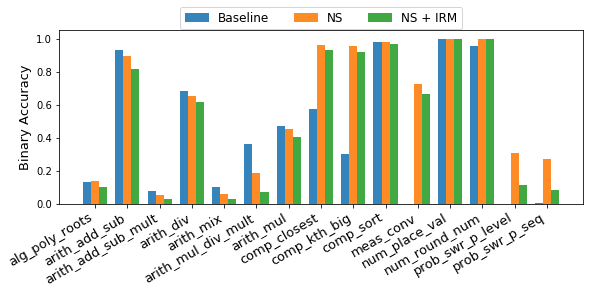

results_interpolation_100k - 0.4386333333333333
ns_20200316_inter_96000 - 0.5745933333333333
risk_irm_ns_20200328_inter_40000 - 0.5160733333333334


pred_valid_algebra__polynomial_roots_big_src_test.txt_100000.txt 0.043
pred_valid_algebra__polynomial_roots_big_src_test.txt_96000.txt 0.0491
pred_valid_algebra__polynomial_roots_big_src_test.txt_40000.txt 0.0333

pred_valid_arithmetic__add_or_sub_big_src_test.txt_100000.txt 0.7744
pred_valid_arithmetic__add_or_sub_big_src_test.txt_96000.txt 0.7369
pred_valid_arithmetic__add_or_sub_big_src_test.txt_40000.txt 0.5992

pred_valid_arithmetic__add_sub_multiple_longer_src_test.txt_100000.txt 0.0125
pred_valid_arithmetic__add_sub_multiple_longer_src_test.txt_96000.txt 0.0246
pred_valid_arithmetic__add_sub_multiple_longer_src_test.txt_40000.txt 0.0137

pred_valid_arithmetic__div_big_src_test.txt_100000.txt 0.5306
pred_valid_arithmetic__div_big_src_test.txt_96000.txt 0.5018
pred_valid_arithmetic__div_big_src_test.txt_40000.txt 0.4668

pred_valid_ar

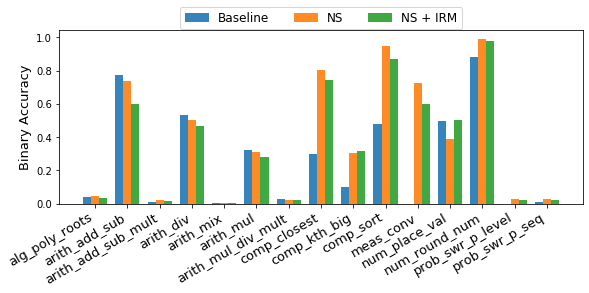

results_extrapolation_100k - 0.2658333333333333
ns_20200316_extra_96000 - 0.3913066666666667
risk_irm_ns_20200328_extra_40000 - 0.3646


In [71]:
plot_accuracies(inter_targets, 
                inter_target_folders, 
                inter_hyp_files,
                targets_inter_names, 
                title='Interpolation Binary Accuracies', 
                file='/Users/ff/dev/mlp-project/report_figs/interpolation_short.pdf')

print()
print()

plot_accuracies(extra_targets, 
                extra_target_folders, 
                extra_hyp_files, 
                targets_extra_names, 
                title='Extrapolation Binary Accuracies', 
                file='/Users/ff/dev/mlp-project/report_figs/extrapolation_short.pdf')